# Hydrology example from the Vistula catchment in Poland

The Vistula catchment is the largest catchment in Poland, with an area of 194,424 km2. This notebook shows how a hydrolgoical model can evaluated using ModelSkill.  

In [1]:
from pathlib import Path
import modelskill as ms
import pandas as pd

In [2]:
fldr = Path("../tests/testdata/Vistula")
df = pd.read_csv(fldr / "stations.csv", index_col=0)
df

,Station,Long,Lat,Area
Id,,,,
6458010,VISTULA (TCZEW),18.80556,54.08722,193922.9
6458500,VISTULA (WARSAW (WARSZAWA)),21.03250,52.24750,84945.1
6458753,PILICA (PRZEDBORZ),19.87528,51.08944,2550.1
6458715,WIEPRZ (LUBARTOW),22.64361,51.49806,6389.8
6458713,WIEPRZ (KRASNYSTAW),23.17667,50.98528,3010.2
6458520,KAMIENNA (KUNOW),21.27889,50.96194,1110.4
6458460,VISTULA (SANDOMIERZ),21.74611,50.67250,31809.9
6458450,VISTULA (SZCZUCIN),21.07722,50.32694,23869.3
6458406,DUNAJEC (NOWY SACZ),20.68722,49.62722,4337.4


In [3]:
def get_comparer(df, mods, id):
    """Helper function to get a Comparer object for a given model and station id"""
    q = ms.Quantity(name="Discharge", unit="m3/s")

    # create Observation object
    dfd = pd.read_csv(fldr / mods[0] / f"{id}.csv", index_col=0, parse_dates=True)
    o = ms.PointObservation(dfd, item="Qobs", name=df.loc[id].Station, x=df.loc[id].Long, y=df.loc[id].Lat, quantity=q)
    
    # create ModelResult objects
    mm = []
    for m in mods:
        dfd = pd.read_csv(fldr / m / f"{id}.csv", index_col=0, parse_dates=True)
        mm.append(ms.PointModelResult(dfd, item="Qsim", name=m, quantity=q))
    
    return ms.compare(obs=o, mod=mm)[0]

In [4]:
# def get_comparer_from_matched(df, mod, id):
#     """Helper function to get a Comparer object for a given model and station id"""
#     q = ms.Quantity(name="Discharge", unit="m3/s")
#     dfd = pd.read_csv(fldr / mod / f"{id}.csv", index_col=0, parse_dates=True)
#     dfd = dfd.rename(columns={"Qsim": mod, "Qobs": df.loc[id].Station})
#     cmp = ms.from_matched(dfd, obs_item=df.loc[id].Station, mod_items=[mod], quantity=q)
#     cmp.data.attrs['x'] = df.loc[id].Long
#     cmp.data.attrs['y'] = df.loc[id].Lat
#     cmp.data.attrs['area'] = df.loc[id].Area
#     return cmp

## Compare a single observation with two model results

In [5]:
cmp = get_comparer(df, ["sim1","sim2"], df.index[0])
cmp

<Comparer>
Quantity: Discharge [m3/s]
Observation: VISTULA (TCZEW), n_points=3653
 Model: sim1, rmse=442.686
 Model: sim2, rmse=331.543

### Plots

timeseries, scatter, boxplot, hist, kde, qq, taylor

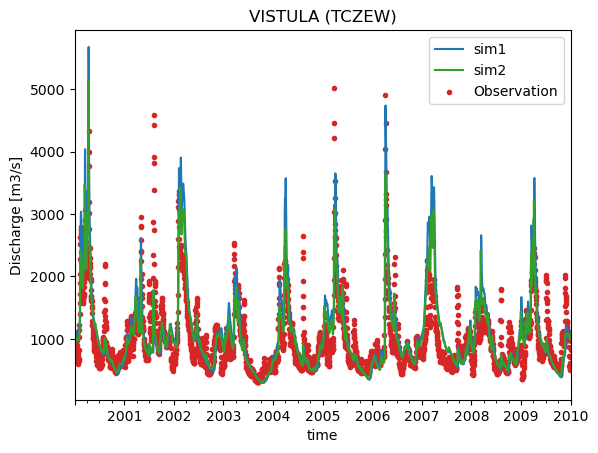

In [6]:
cmp.plot.timeseries();  # backend="plotly"

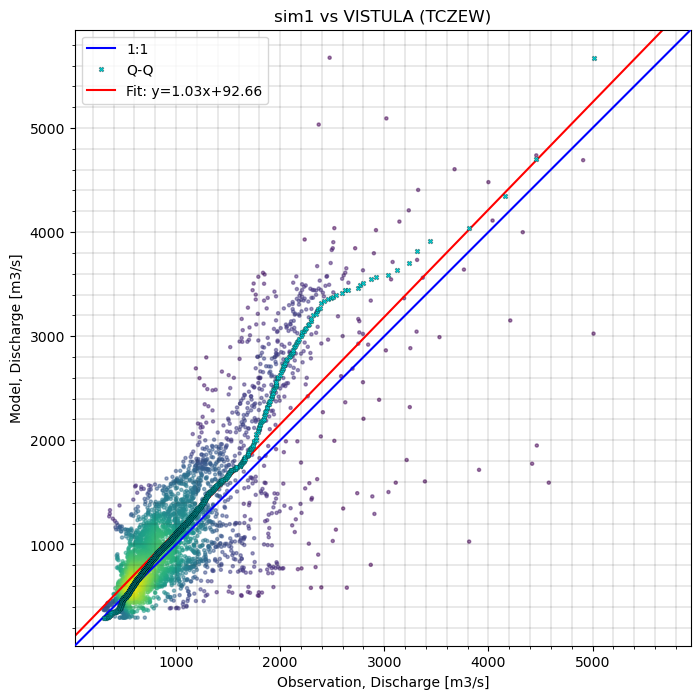

In [7]:
cmp.sel(model="sim1").plot.scatter();  # backend="plotly"

In [8]:
# cmp.plot.kde(xlim=[0,5000]);  

### Summary statistics

In [9]:
#ms.options.metrics.list = ["kge", "cc"]
#ms.reset_option("metrics.list")

In [10]:
cmp.skill().round(3)

,observation,n,bias,rmse,urmse,mae,cc,si,r2
model,,,,,,,,,
sim1,VISTULA (TCZEW),3653,123.045,442.686,425.242,304.846,0.794,0.431,0.325
sim2,VISTULA (TCZEW),3653,53.854,331.543,327.140,220.509,0.829,0.331,0.622


### Statistics aggregated by month

In [11]:
cmp.data["month"] = cmp.time.to_series().dt.month

In [12]:
cmp.skill(by=["model","month"]) #.plot.bar("kge");

observation    n        bias        rmse       urmse  \
model month                                                             
sim1  1      VISTULA (TCZEW)  310  204.570000  353.207885  287.935627   
      2      VISTULA (TCZEW)  283  361.378445  607.123971  487.857700   
      3      VISTULA (TCZEW)  310  472.498710  760.379191  595.752871   
      4      VISTULA (TCZEW)  300  499.693333  683.288229  466.035810   
      5      VISTULA (TCZEW)  310  219.354194  351.165280  274.227628   
      6      VISTULA (TCZEW)  300  101.385667  293.222662  275.137195   
      7      VISTULA (TCZEW)  310   10.764839  329.925487  329.749822   
      8      VISTULA (TCZEW)  310 -161.391613  520.810526  495.173052   
      9      VISTULA (TCZEW)  300  -51.441000  235.691808  230.009677   
      10     VISTULA (TCZEW)  310 -119.369355  215.007384  178.827101   
      11     VISTULA (TCZEW)  300 -142.712667  237.991246  190.454530   
      12     VISTULA (TCZEW)  310   99.818387  276.816425  258.192995   
sim2  1      VISTULA (TCZEW)  310  141.046774  263.271368  222.300744   
      2      VISTULA (TCZEW)  283  140.469965  342.516807  312.387503   
      3      VISTULA (TCZEW)  310  261.094516  549.377763  483.368989   
      4      VISTULA (TCZEW)  300  206.251667  444.299215  393.525149   
      5      VISTULA (TCZEW)  310  128.856774  314.699864  287.109624   
      6      VISTULA (TCZEW)  300   79.713333  240.785226  227.207636   
      7      VISTULA (TCZEW)  310   11.325161  294.930110  294.712590   
      8      VISTULA (TCZEW)  310 -140.289677  488.335349  467.750168   
      9      VISTULA (TCZEW)  300  -39.807000  192.768504  188.613623   
      10     VISTULA (TCZEW)  310 -104.533548  165.867877  128.782335   
      11     VISTULA (TCZEW)  300 -110.754667  188.687183  152.762092   
      12     VISTULA (TCZEW)  310   77.841613  217.960054  203.586022   

                    mae        cc        si        r2  
model month                                            
sim1  1      274.710000  0.440905  0.348448 -0.797695  
      2      497.490106  0.803975  0.368014  0.137070  
      3      606.407097  0.730561  0.398532 -0.391647  
      4      566.473333  0.834517  0.275612 -0.235966  
      5      303.336774  0.697614  0.253664  0.146342  
      6      240.581000  0.493330  0.314786  0.127434  
      7      248.576452  0.298390  0.432754  0.083908  
      8      267.783871  0.667376  0.566533  0.251591  
      9      127.612333  0.552289  0.343482  0.269807  
      10     147.021613  0.717061  0.253086  0.280901  
      11     167.054667  0.741710  0.238625  0.284728  
      12     224.088065  0.452674  0.334572 -1.025831  
sim2  1      206.861613  0.622109  0.269019  0.001237  
      2      280.057244  0.887547  0.235649  0.725347  
      3      406.852581  0.767161  0.323352  0.273541  
      4      298.948333  0.809858  0.232729  0.477423  
      5      251.843871  0.655435  0.265580  0.314427  
      6      190.837333  0.695364  0.259950  0.411613  
      7      228.633548  0.540092  0.386773  0.267942  
      8      248.914194  0.773781  0.535159  0.342015  
      9      105.391000  0.741995  0.281664  0.511550  
      10     122.738710  0.863399  0.182260  0.572037  
      11     134.377333  0.840079  0.191399  0.550392  
      12     170.919032  0.560932  0.263811 -0.255953

In [13]:
# season
# season_int = cmp.time.to_series().dt.month%12 // 3 + 1
# cmp.data["season"] = season_int.map({1:"Winter", 2:"Spring", 3:"Summer", 4:"Autumn"})

In [14]:
# cmp.skill(by=["model","season"]).plot.grid("rmse")

## Compare multiple observations with two model results

In [15]:
# loop through all stations in df and create a Comparer for each
cmps = [get_comparer(df, ["sim1","sim2"], id) for id in df.index]
cc = ms.ComparerCollection(cmps)
cc   

<ComparerCollection>
Comparer: VISTULA (TCZEW)
Comparer: VISTULA (WARSAW (WARSZAWA))
Comparer: PILICA (PRZEDBORZ)
Comparer: WIEPRZ (LUBARTOW)
Comparer: WIEPRZ (KRASNYSTAW)
Comparer: KAMIENNA (KUNOW)
Comparer: VISTULA (SANDOMIERZ)
Comparer: VISTULA (SZCZUCIN)
Comparer: DUNAJEC (NOWY SACZ)
Comparer: POPRAD (CHMELNICA)
Comparer: WISLOK (TRYNCZA)
Comparer: PISA (PTAKI)
Comparer: NAREW (SURAZ)
Comparer: LIWIEC (LOCHOW)
Comparer: KRZNA (MALOWA GORA)

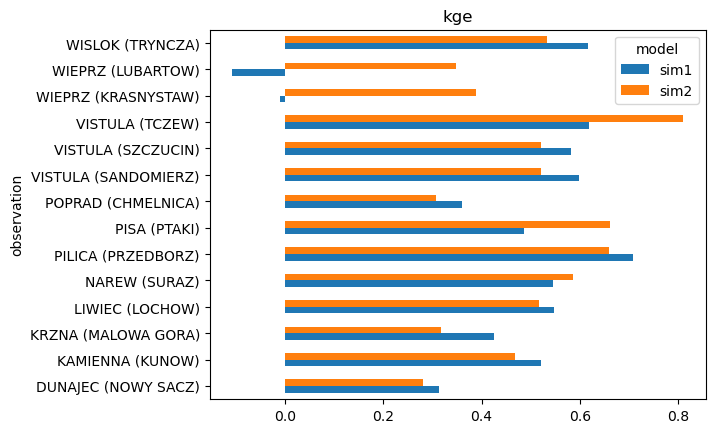

In [16]:
cc.skill(by=["model","observation"], metrics="kge").plot.barh("kge");

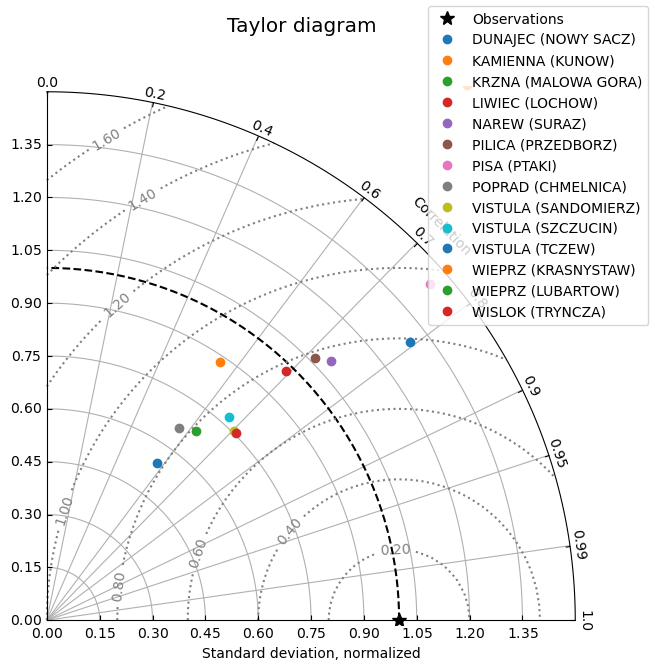

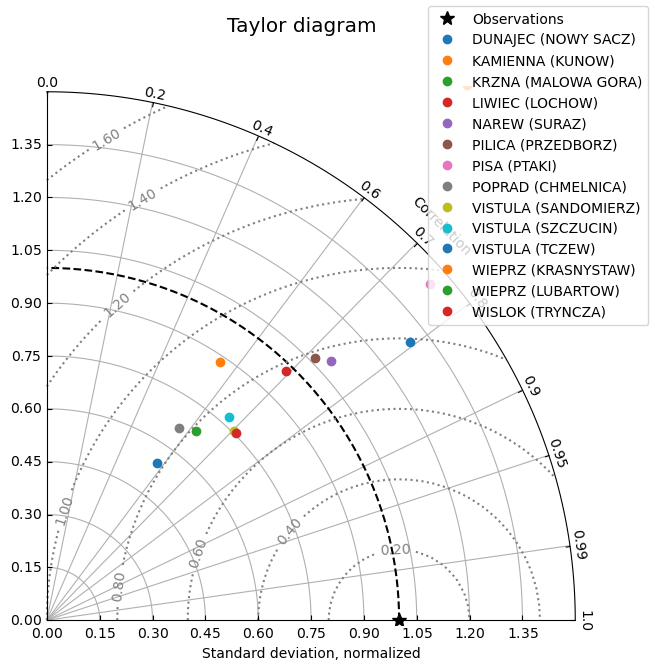

In [17]:
cc.sel(model="sim1").plot.taylor(normalize_std=True, aggregate_observations=False)